In [7]:
!unrar x "/content/book.rar" "/content"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/book.rar


Would you like to replace the existing file /content/book/102010.png
 13294 bytes, modified on 2022-09-25 10:33
with a new one
 13294 bytes, modified on 2022-09-25 10:33

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit A

Extracting  /content/book/102010.png                                       0%  OK 
Extracting  /content/book/102209.png                                       0%  OK 
Extracting  /content/book/102257.png                                       1%  OK 
Extracting  /content/book/102268.png                                       1%  OK 
Extracting  /content/book/102967.png                                       2%  OK 
Extracting  /content/book/103111.png                                       2%  OK 
Extracting  /content/book/10325.png                                        2%  OK 
Extracting  /content/book/10374

In [8]:
#Importing librarie
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import cv2
from PIL import Image
import keras
import numpy as np
import random
from keras.models import Sequential, Model
from tensorflow.keras.layers import Input
from keras.layers import LeakyReLU
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import MaxPool2D, AvgPool2D
from keras.layers import UpSampling2D
from keras.layers import Lambda
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Add, Multiply
from keras.losses import mse, binary_crossentropy
import keras.backend as K
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

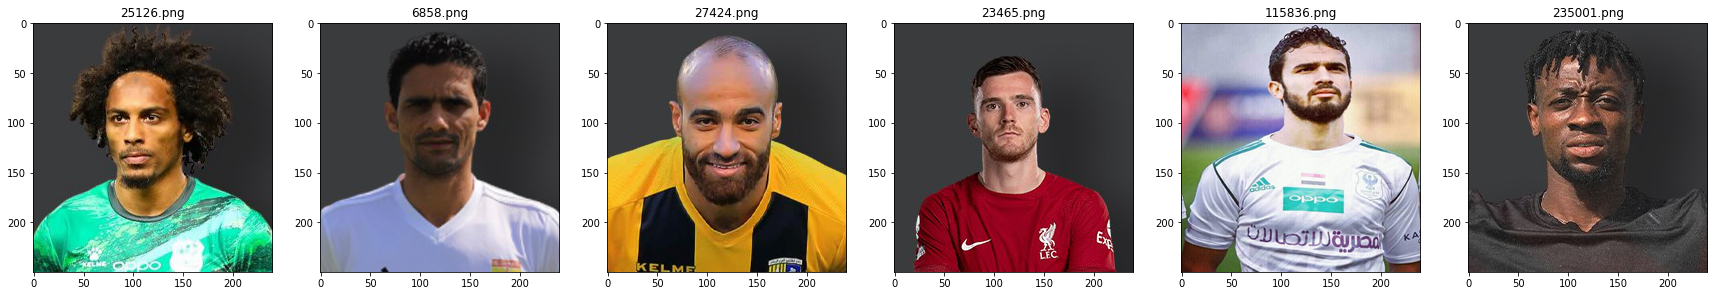

In [67]:
plt.figure(figsize=(30,20))
img_folder=r"/content/book"
for i in range(6):
    file = random.choice(os.listdir(img_folder))
    image_path= os.path.join(img_folder, file)
    img=Image.open(image_path)
    ax=plt.subplot(1,6,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

In [42]:
img_size = 128
def create_datasets(ROOT):
    imgs = []
    for f in (os.listdir(ROOT)):
        img = cv2.imread(ROOT+'/'+f)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, ( img_size , img_size ))
        imgs.append(img)    
    imgs = np.array(imgs)
    imgs = np.divide(imgs,255)
    return imgs
train_x = create_datasets('/content/book')

In [43]:
train_x.shape

(232, 128, 128, 3)

In [44]:
latent_dims = 10

In [45]:
encoder_in = Input(shape=(img_size,img_size,3))  
encoder_l1 = Conv2D(filters=32, kernel_size=5, strides=1, padding='same', input_shape=(64,64,3))(encoder_in)
encoder_l1 = BatchNormalization()(encoder_l1)
encoder_l1 = Activation(LeakyReLU(0.2))(encoder_l1)

encoder_l1 = Conv2D(filters=64, kernel_size=5, strides=2, padding='same')(encoder_l1)
encoder_l1 = BatchNormalization()(encoder_l1)
encoder_l1 = Activation(LeakyReLU(0.2))(encoder_l1)


encoder_l2 = Conv2D(filters=128, kernel_size=5, strides=2, padding='same')(encoder_l1)
encoder_l2 = BatchNormalization()(encoder_l2)
encoder_l2 = Activation(LeakyReLU(0.2))(encoder_l2)

encoder_l3 = Conv2D(filters=256, kernel_size=5, strides=2, padding='same')(encoder_l2)
encoder_l3 = BatchNormalization()(encoder_l3)
encoder_l3 = Activation(LeakyReLU(0.2))(encoder_l3)


encoder_l4 = Conv2D(filters=512, kernel_size=5, strides=2, padding='same')(encoder_l3)
encoder_l4 = BatchNormalization()(encoder_l4)
encoder_l4 = Activation(LeakyReLU(0.2))(encoder_l4)

flatten = Flatten()(encoder_l4)

encoder_dense = Dense(1024)(flatten)
encoder_dense = BatchNormalization()(encoder_dense)
encoder_out = Activation(LeakyReLU(0.2))(encoder_dense)


mu = Dense(latent_dims)(encoder_out)
log_var = Dense(latent_dims)(encoder_out)


epsilon = Input(tensor=K.random_normal(shape=(K.shape(mu)[0], latent_dims)))  ##INPUT EPSILON FOR RANDOM SAMPLING

sigma = Lambda(lambda x: K.exp(0.5 * x))(log_var) # CHANGE log_var INTO STANDARD DEVIATION(sigma)
z_eps = Multiply()([sigma, epsilon])

z = Add()([mu, z_eps])

encoder=Model([encoder_in,epsilon], z, name = "Encoder")
encoder.summary()


Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  2432        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_32 (BatchN  (None, 128, 128, 32  128        ['conv2d_15[0][0]']              
 ormalization)                  )                                                           

In [46]:
decoder = Sequential()
decoder.add(Dense(1024, input_shape=(latent_dims,)))
decoder.add(BatchNormalization())
decoder.add(Activation(LeakyReLU(0.2)))

decoder.add(Dense(8192))
decoder.add(BatchNormalization())
decoder.add(Activation(LeakyReLU(0.2)))

decoder.add(Reshape(target_shape=(4,4,512)))

decoder.add(Conv2DTranspose(filters=256, kernel_size=5, strides=2, padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation(LeakyReLU(0.2)))

decoder.add(Conv2DTranspose(filters=256, kernel_size=5, strides=2, padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation(LeakyReLU(0.2)))

decoder.add(Conv2DTranspose(filters=128, kernel_size=5, strides=2, padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation(LeakyReLU(0.2)))

decoder.add(Conv2DTranspose(filters=64, kernel_size=5, strides=2, padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation(LeakyReLU(0.2)))


decoder.add(Conv2DTranspose(filters=32, kernel_size=5, strides=2, padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation(LeakyReLU(0.2)))

decoder.add(Conv2DTranspose(filters=3, kernel_size=5, strides=1, padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation('sigmoid'))

decoder.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 1024)              11264     
                                                                 
 batch_normalization_38 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 activation_38 (Activation)  (None, 1024)              0         
                                                                 
 dense_17 (Dense)            (None, 8192)              8396800   
                                                                 
 batch_normalization_39 (Bat  (None, 8192)             32768     
 chNormalization)                                                
                                                                 
 activation_39 (Activation)  (None, 8192)             

In [47]:
vae_preds = decoder(z)
vae = Model( [encoder_in, epsilon] , vae_preds, name = "VAE")
vae.summary()

Model: "VAE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  2432        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_32 (BatchN  (None, 128, 128, 32  128        ['conv2d_15[0][0]']              
 ormalization)                  )                                                               

In [48]:
def reconstruction_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

def kl_loss(y_true, y_pred):
    kl_loss = - 0.5 * K.mean(1 + log_var - K.square(mu) - K.exp(log_var), axis=-1)
    return kl_loss

def vae_loss(y_true, y_pred):
    return reconstruction_loss(y_true, y_pred) + 0.03 * kl_loss(y_true, y_pred)   #scaling kl_loss by 0.03 seem to help

In [49]:
vae.compile(optimizer='adam', loss=vae_loss , metrics=[reconstruction_loss, kl_loss])

In [50]:
vae.fit(train_x, train_x, epochs=300, batch_size=100)

Train on 232 samples
Epoch 1/300
232/232 [==============================] - 6s 24ms/sample - loss: 1068.3496 - reconstruction_loss: 0.1066 - kl_loss: 35607.8945
Epoch 2/300
232/232 [==============================] - 1s 5ms/sample - loss: 1871.9402 - reconstruction_loss: 0.0884 - kl_loss: 62395.1211
Epoch 3/300
232/232 [==============================] - 1s 5ms/sample - loss: 45566.1554 - reconstruction_loss: 0.0853 - kl_loss: 1518869.1250
Epoch 4/300
232/232 [==============================] - 1s 5ms/sample - loss: 13303.6525 - reconstruction_loss: 0.0852 - kl_loss: 443452.2500
Epoch 5/300
232/232 [==============================] - 1s 5ms/sample - loss: 1.3665 - reconstruction_loss: 0.0831 - kl_loss: 42.8207
Epoch 6/300
232/232 [==============================] - 1s 5ms/sample - loss: 2.1603 - reconstruction_loss: 0.0798 - kl_loss: 69.3149
Epoch 7/300
232/232 [==============================] - 1s 5ms/sample - loss: 12.0831 - reconstruction_loss: 0.0802 - kl_loss: 400.0761
Epoch 8/300
232/

In [53]:
def plot_images(rows, cols, images, title):
    grid = np.zeros(shape=(rows*128, cols*128, 3))
    for row in range(rows):
        for col in range(cols):
            grid[row*128:(row+1)*128, col*128:(col+1)*128, :] = images[row*cols + col]

    plt.figure(figsize=(20,10))       
    plt.imshow(grid)
    plt.title(title)
    plt.show()

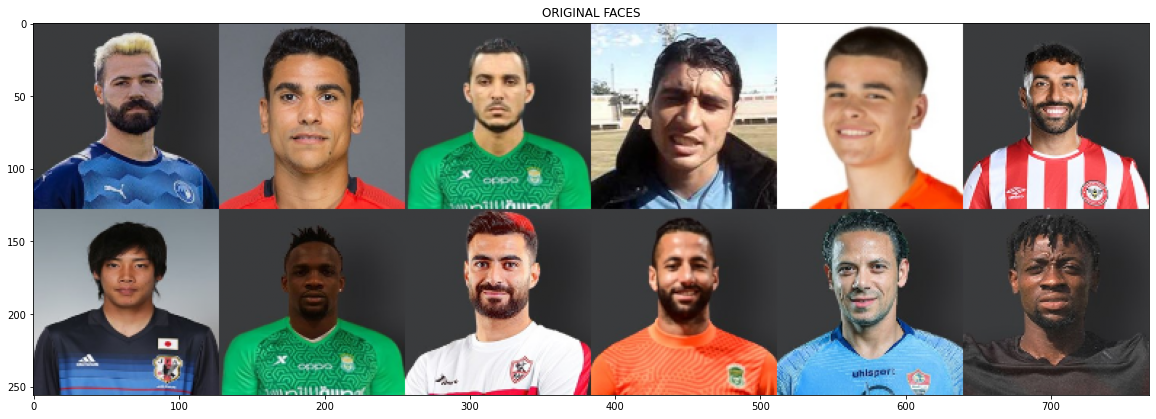

In [62]:
predictions = train_x[50:62]
plot_images(2,6,predictions,"ORIGINAL FACES")

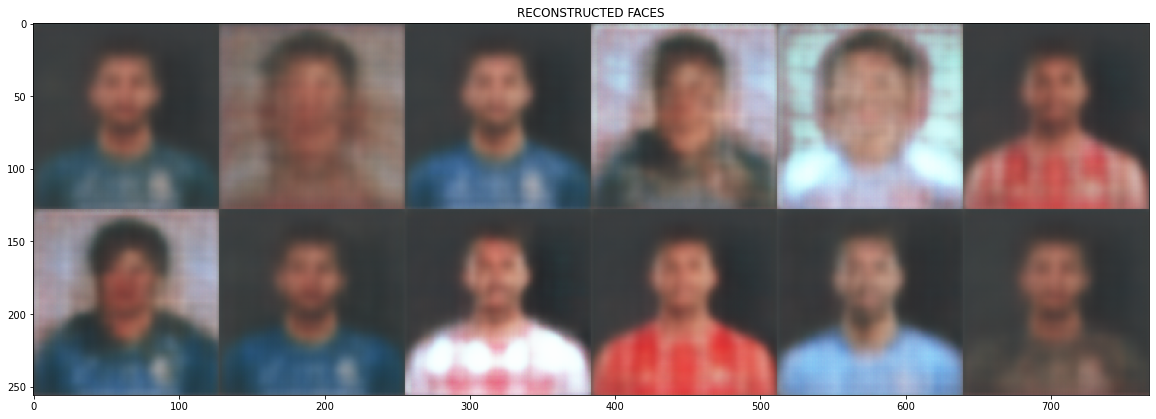

In [61]:
predictions  = vae.predict(train_x[50:62])
plot_images(2,6,predictions, "RECONSTRUCTED FACES")

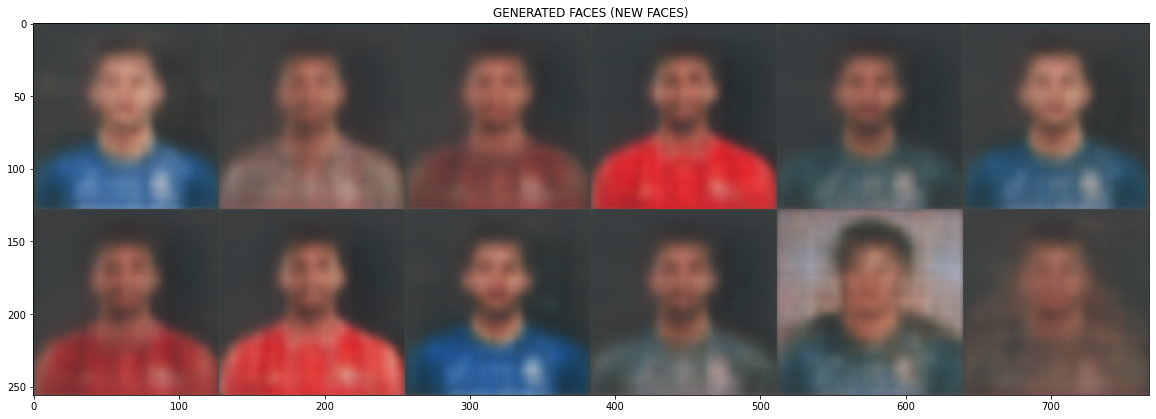

In [63]:
predictions= decoder.predict(np.random.randn(12, latent_dims))
plot_images(2,6,predictions, "GENERATED FACES (NEW FACES)")